In [6]:
import os
import pandas as pd
import lingam
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

plt.style.use('ggplot')

In [7]:
class LassoWrapper():
    def __init__(self, model_params={'fit_intercept': True, 'max_iter': 100000}):
        self.model_name = "lasso"
        self.search_type = 'random'
        self.param_grid = {'alpha': np.linspace(0.001, 0.05, 100)}
        if model_params is None:
            self.ModelClass = Lasso()
        else:
            self.ModelClass = Lasso(**model_params)

def tscv_opt(X, y, model_wrapper, n_splits, n_iter, seed, verbose, n_jobs, scoring):

    # define time series split
    time_split = TimeSeriesSplit(n_splits=n_splits)

    # choose search type
    if model_wrapper.search_type == 'random':
        model_search = RandomizedSearchCV(estimator=model_wrapper.ModelClass,
                                        param_distributions=model_wrapper.param_grid,
                                        n_iter=n_iter,
                                        cv=time_split,
                                        verbose=verbose,
                                        n_jobs=n_jobs,
                                        scoring=scoring,
                                        random_state=seed)
    elif model_wrapper.search_type == 'grid':
        model_search = GridSearchCV(estimator=model_wrapper.ModelClass,
                                    param_grid=model_wrapper.param_grid,
                                    cv=time_split,
                                    verbose=verbose,
                                    n_jobs=n_jobs,
                                    scoring=scoring)
    else:
        raise Exception('search type method not registered')

    # find best model
    model_fit = model_search.fit(X, y)

    return model_fit

In [8]:
df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'inputs', 'big_monthly_ret_etfs_macro_transf.csv'))
df.set_index('date', inplace=True)

des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

df.tail()

,SPY,XLI,XLE,XLK,XLV,XLU,XLF,XLY,XLP,XLB,...,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA
date,,,,,,,,,,,,,,,,,,,,,
2022-04-01,0.034068,0.030304,0.112218,0.026279,0.052945,0.110821,-0.022764,0.050035,0.009701,0.054679,...,0.000000,-0.000384,0.006619,0.003329,0.003480,0.003943,0.001993,0.001709,-0.003765,0.003986
2022-06-01,-0.018577,-0.026422,0.168738,-0.013195,-0.012050,0.021246,-0.011113,-0.094876,-0.067722,-0.002931,...,0.018105,0.004665,0.007818,0.012089,0.014690,0.012330,0.009861,0.007153,0.021173,0.006597
2022-07-01,-0.085476,-0.080340,-0.198652,-0.104607,-0.032919,-0.047829,-0.109524,-0.093679,-0.024020,-0.164352,...,-0.006158,0.003295,0.003632,-0.002069,-0.003218,-0.000754,-0.000932,-0.002165,-0.005561,0.000872
2022-08-01,0.055509,0.077391,0.041338,0.082228,0.013328,0.062137,0.036556,0.117837,0.037419,0.021784,...,-0.004755,0.003005,0.006746,0.001421,0.000255,0.002013,0.002679,0.004809,-0.008099,0.005841
2022-09-01,-0.024051,-0.006960,0.043734,-0.053801,-0.046455,0.028106,-0.002711,0.001148,-0.020864,-0.035379,...,-0.001806,-0.001200,0.007886,0.003543,0.002526,0.003887,0.003437,0.004459,-0.004180,0.005732


In [65]:
start_window = 12 * 8
p = 1
correl_window = 1000
min_periods = 12
beta_threshold = 0 # 0.05
start = 0
end = start + start_window
incercept = True
fs_name = "lasso"

etfs = ["SPY" ,"XLI" ,"XLE" ,"XLK" ,"XLV", "XLU" ,"XLF" ,"XLY" ,"XLP" ,"XLB"]
targets = ["XLE"] #, "XLE", "XLV"]

train_val_df = df.loc[:"2022-01-01"]
test_df = df.loc["2022-01-01":]

all_parents_of_targets = {}
all_predictions = {}
for target in targets:

    copy_etfs = [var for var in etfs if var != target]
    target_df = train_val_df.drop(copy_etfs, axis=1)

    # compute correlation matrix
    corr = target_df.drop([target], axis=1).corr()

    # compute forward looking cluster of the correlation matrix
    kmeans = KMeans(n_clusters=20, random_state=0, n_init="auto").fit(corr)

    # label clusters
    clusters_df = pd.DataFrame({"fred": target_df.drop([target], axis=1).columns, "cluster": kmeans.labels_})
    clusters_df.sort_values(by="cluster")
    clusters_df = pd.merge(clusters_df, des[["fred", "description"]], on='fred')

    # compute rolling correlation for each cluster and rank them
    correl_dict = {}
    rank_list = []
    for c in np.unique(kmeans.labels_):
        clustes_variables = clusters_df.loc[clusters_df['cluster'] == c]['fred'].values

        clusters_features_df = target_df[[target] + list(clustes_variables)]
        
        # compute rolling correlation
        rolling_corr_df = clusters_features_df.rolling(window=correl_window, min_periods=min_periods).corr()

        # compute correlation with the target
        rolling_corr_df = rolling_corr_df[[target]].reset_index()
        rolling_corr_df = rolling_corr_df.loc[rolling_corr_df["level_1"] != target]
        rolling_corr_df = rolling_corr_df.pivot_table(index=["date"], columns=["level_1"])
        rolling_corr_df.columns = rolling_corr_df.columns.droplevel()

        # save correl
        correl_dict[c] = rolling_corr_df

        # compute rankings given correl
        rank_df = rolling_corr_df.rank(axis=1, ascending=False)

        # save rank
        rank_list.append(rank_df)
    final_rank_df = pd.concat(rank_list, axis=1)

    target_subset_df = target_df.iloc[(min_periods-1):, :]

    predictions = []
    parents_of_target = []
    for step in tqdm(range(0, len(target_subset_df) - start_window, 1), total=len(target_subset_df) - start_window, desc="rolling {}: {}".format(fs_name, target)):

        # select features and time window
        selected_columns = list(final_rank_df.iloc[(end + step)].index[(final_rank_df.iloc[(end + step)] == 1)])
        Xt = target_subset_df.iloc[start:(end + step), :][[target] + selected_columns]
        Xt_test = target_subset_df.iloc[(end + step - p):(end + step + 1), :][[target] + selected_columns]

        if fs_name == "var-lingam":
            yt = Xt[[target]]

            # run VARLiNGAM
            var_lingam = lingam.VARLiNGAM(lags=p)
            var_lingam_fit = var_lingam.fit(Xt)

            # build labels - ONLY WORKS FOR k=1
            labels0 = []
            labels1 = []
            for i in range(p+1):
                for colname in Xt.columns:
                    if i == 0:
                        labels0.append("{}(t)".format(colname, i))
                    else:
                        labels1.append("{}(t-{})".format(colname, i))

            B0 = var_lingam_fit.adjacency_matrices_[0]
            B1 = var_lingam_fit.adjacency_matrices_[1]

            B0_df = pd.DataFrame(B0, columns=labels0, index=labels0)
            B1_df = pd.DataFrame(B1, columns=labels1, index=labels0)

            selected_variables = list(B1_df.loc["{target}(t)".format(target=target)][np.abs(B1_df.loc["{target}(t)".format(target=target)]) > beta_threshold].index)

            # create lags of Xt variables
            for c in Xt.columns:
                for lag in range(1, p + 1):
                    Xt["{}(t-{})".format(c, lag)] = Xt[c].shift(lag)
                    Xt_test["{}(t-{})".format(c, lag)] = Xt_test[c].shift(lag)
                
                Xt.drop(c, axis=1, inplace=True)

        elif fs_name == "lasso":
            yt = Xt[[target]]
            Xt = Xt.drop([target], axis=1)
            
            # create lags of Xt variables
            for c in Xt.columns:
                for lag in range(1, p + 1):
                    Xt["{}(t-{})".format(c, lag)] = Xt[c].shift(lag)
                    Xt_test["{}(t-{})".format(c, lag)] = Xt_test[c].shift(lag)
                
                Xt.drop(c, axis=1, inplace=True)

            Xt = Xt.dropna()
            yt = yt.loc[Xt.index]

            # train lasso model
            model_fit = tscv_opt(X=Xt,
                                 y=yt,
                                 model_wrapper=LassoWrapper(),
                                 n_splits=2,
                                 n_iter=10,
                                 seed=2294,
                                 verbose=False,
                                 n_jobs=1,
                                 scoring=make_scorer(mean_squared_error))

            # fit best model
            lasso_best_fit = model_fit.best_estimator_.fit(Xt, yt)
            B1_df = pd.DataFrame(lasso_best_fit.coef_, index=Xt.columns, columns=["SPY(t)"]).sort_values(ascending=False, by="SPY(t)")

            # select variables with beta > threshold
            selected_variables = list(B1_df[B1_df > beta_threshold].dropna().index)

        parents_of_target.append(pd.DataFrame(1, index=selected_variables, columns=[Xt.index[-1]]).T)
        if len(selected_variables) != 0:
            Xt_selected_train = []
            Xt_selected_test = []
            for full_vname in selected_variables:
                Xt_selected_train.append(Xt[full_vname])
                Xt_selected_test.append(Xt_test[full_vname])

            Xt_selected_train = pd.concat(Xt_selected_train, axis=1)
            Xt_selected_train = pd.concat([yt, Xt_selected_train], axis=1)
            Xt_selected_train = Xt_selected_train.dropna()

            Xt_selected_test = pd.concat(Xt_selected_test, axis=1)
            Xt_selected_test = Xt_selected_test.dropna()

            if incercept:
                Xt_selected_train['const'] = 1
                Xt_selected_test['const'] = 1

            # linear regression estimate and prediction
            model = sm.OLS(endog=Xt_selected_train[target], exog=Xt_selected_train.drop([target], axis=1))
            model_fit = model.fit()
            ypred = model_fit.predict(Xt_selected_test)

            predictions.append(ypred)
        else:
            predictions.append(pd.Series(0, index=[Xt_test.index[-1]]))
    predictions_df = pd.DataFrame(pd.concat(predictions, axis=0), columns=['{}_pred'.format(target)])
    parents_of_targets_df = pd.concat(parents_of_target, axis=0)

    all_predictions[target] = predictions_dfs
    all_parents_of_targets[target] = parents_of_targets_df

rolling lasso: XLE: 100%|██████████| 79/79 [00:05<00:00, 13.59it/s]


In [66]:
target = 'XLE'

compare_df = pd.concat([train_val_df[[target]], all_predictions[target][['{}_pred'.format(target)]]], axis=1)
compare_df.index = pd.to_datetime(compare_df.index)

# compute mean squared error
compare_df['diff'] = compare_df['{}_pred'.format(target)] - compare_df[target]
compare_df['diff_squared'] = compare_df['diff'] ** 2
mse = compare_df['diff_squared'].mean()

compare_df.drop(['diff', 'diff_squared'], axis=1, inplace=True)

In [63]:
target = 'XLE'

compare_df = pd.concat([train_val_df[[target]], all_predictions[target][['{}_pred'.format(target)]]], axis=1)
compare_df.index = pd.to_datetime(compare_df.index)
compare_df = pd.concat([compare_df.loc[:"2020-04-01"], compare_df.loc["2020-08-01":]], axis=0)

# compute mean squared error
compare_df['diff'] = compare_df['{}_pred'.format(target)] - compare_df[target]
compare_df['diff_squared'] = compare_df['diff'] ** 2
mse = compare_df['diff_squared'].mean()

compare_df.drop(['diff', 'diff_squared'], axis=1, inplace=True)

In [67]:
mse

0.005367924689807114

In [62]:
mse

0.013253897271292179

In [64]:
mse

0.005725338943278335

In [ ]:
compare_df = pd.concat([train_val_df[[target]], all_predictions[target][['{}_pred'.format(target)]]], axis=1)

In [40]:
parents_of_targets_df.loc["2020-04-01":]

,SPY(t-1),AWHMAN(t-1),S&P: indust(t-1),BUSINVx(t-1),PERMITS(t-1),USTRADE(t-1),M1SL(t-1),S&P PE ratio(t-1),GS1(t-1),COMPAPFFx(t-1),...,IPDCONGD(t-1),T10YFFM(t-1),SRVPRD(t-1),CES1021000001(t-1),PERMITNE(t-1),WPSFD49502(t-1),M2SL(t-1),USFIRE(t-1),PAYEMS(t-1),CES0600000007(t-1)
2020-06-01,1,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1,1,...,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN
2020-07-01,1,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1,1,...,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN
2020-09-01,1,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1,1,...,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN
2020-10-01,1,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1,1,...,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN
2020-12-01,1,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1,1,...,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN
2021-01-01,1,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1,1,...,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN
2021-02-01,1,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1,1,...,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN
2021-03-01,1,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1,1,...,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN
2021-04-01,1,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1,1,...,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN
2021-06-01,1,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1,1,...,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN


<Axes: >

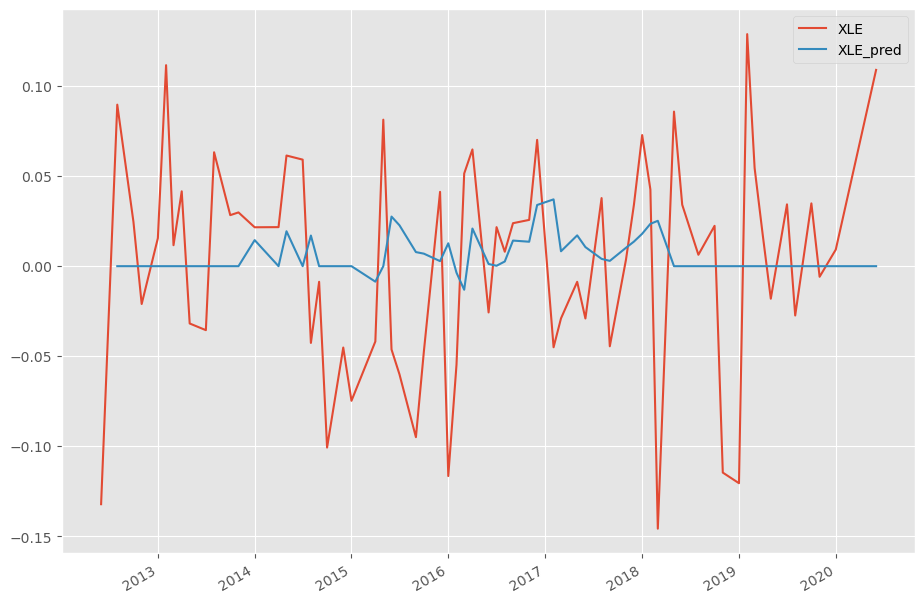

In [69]:
compare_df.loc["2012-06-01":"2020-06-01"].plot(figsize=(11, 8))

<Axes: xlabel='date'>

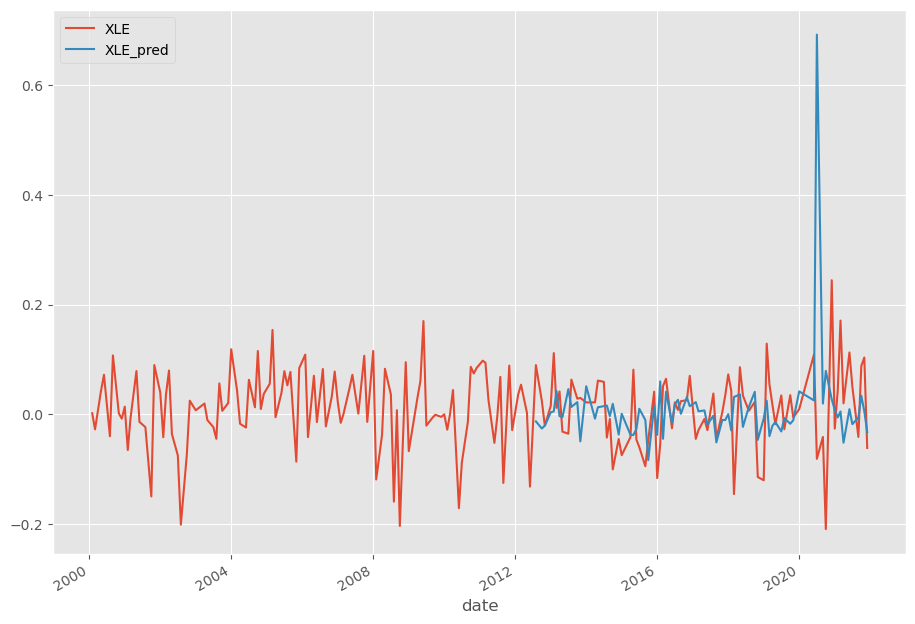

In [59]:
compare_df.plot(figsize=(11, 8))

<Axes: >

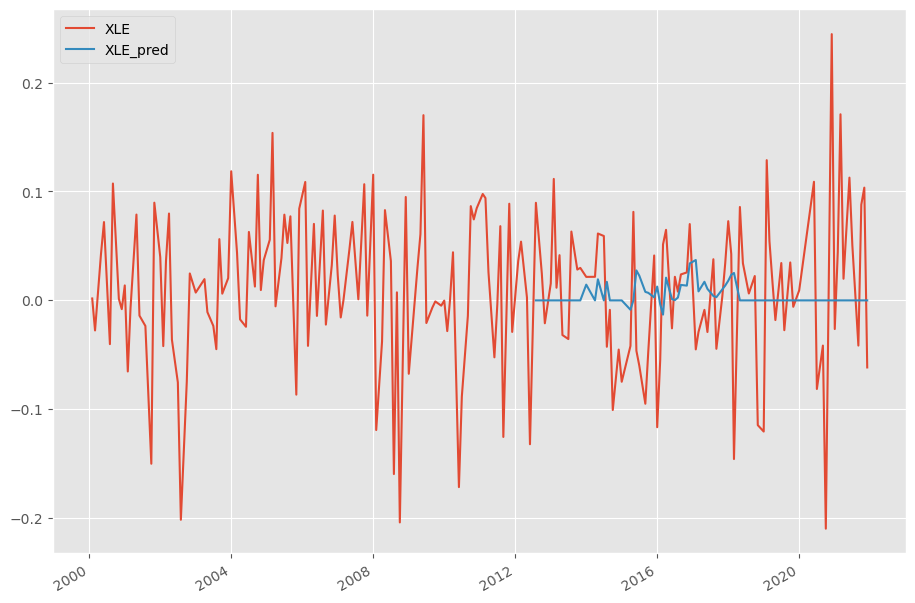

In [68]:
compare_df.plot(figsize=(11, 8))